## Hypothesis Testing 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import networkx as nx
from collections import defaultdict

# Load Data
df_w1 = pd.read_csv('../Cooked/df_w1_prepared.csv')
df_w2 = pd.read_csv('../Cooked/df_w2_prepared.csv') 
df_w3 = pd.read_csv('../Cooked/df_w3_prepared.csv')

G_1 = nx.read_gml("../NA/multiplex_graph_w1.gml")
G_2 = nx.read_gml("../NA/multiplex_graph_w2.gml")
G_3 = nx.read_gml("../NA/multiplex_graph_w3.gml")

## Political-Self-Assessment over Waves (Selbsteinschätzung)

- scale only ranged form 1 to 11 
- "0" values are missings!

In [2]:
def political_identity(df):
    dict_political_identity = {}

    for index, row in df.iterrows():
        participant_id = row['participant.label']
        self_identity = row.get('network_app.1.player.linksrechts_self')

        # If self_identity is 0 or NaN, set to NaN
        if pd.isna(self_identity) or self_identity == 0:
            self_identity = float('nan')
        
        dict_political_identity[participant_id] = {
            'ego': self_identity,
        }
    return dict_political_identity

In [3]:
dict_polident_w1 = political_identity(df_w1)
dict_polident_w2 = political_identity(df_w2)
dict_polident_w3 = political_identity(df_w3)

In [4]:
# delta_ego_alter für Susumu, am besten mit abs() delta und nicht plus/minus 

# Build a DataFrame
df_ego = pd.DataFrame({
    'w1': {pid: data['ego'] for pid, data in dict_polident_w1.items()},
    'w2': {pid: data['ego'] for pid, data in dict_polident_w2.items()},
    'w3': {pid: data['ego'] for pid, data in dict_polident_w3.items()},
})

df_ego.index.name = 'participant_id'
df_ego = df_ego.reset_index()
df_ego_complete = df_ego.dropna()

df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True) 

df_long = df_ego_complete.melt(id_vars='participant_id', 
                      value_vars=['w1', 'w2', 'w3'],
                      var_name='wave', 
                      value_name='ego_score')

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_13317/4294299729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True)


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_13317/1819087568.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')


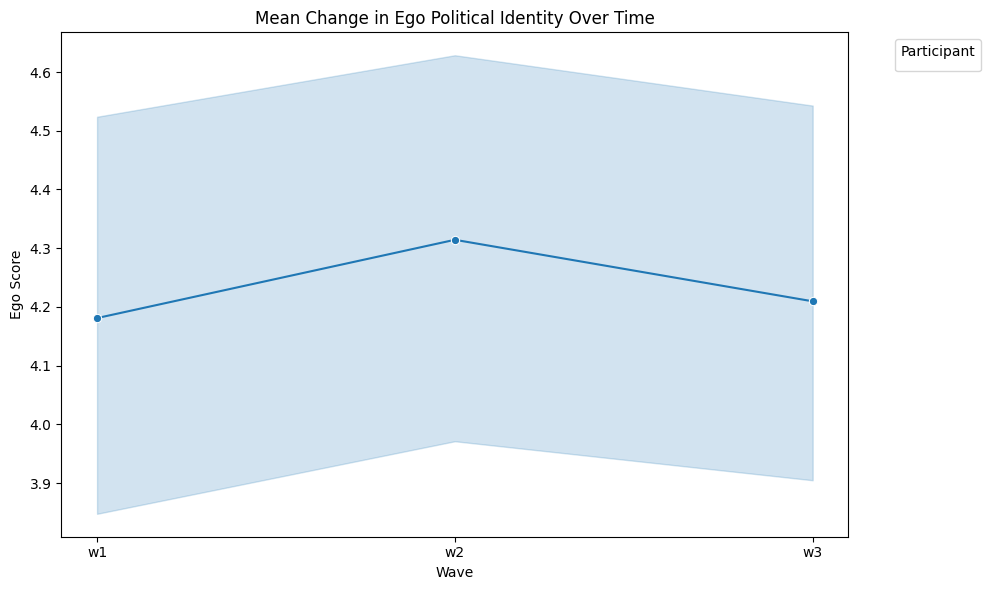

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='wave', y='ego_score', marker='o')
plt.title('Mean Change in Ego Political Identity Over Time')
plt.ylabel('Ego Score')
plt.xlabel('Wave')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_13317/1735861286.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm').reversed()


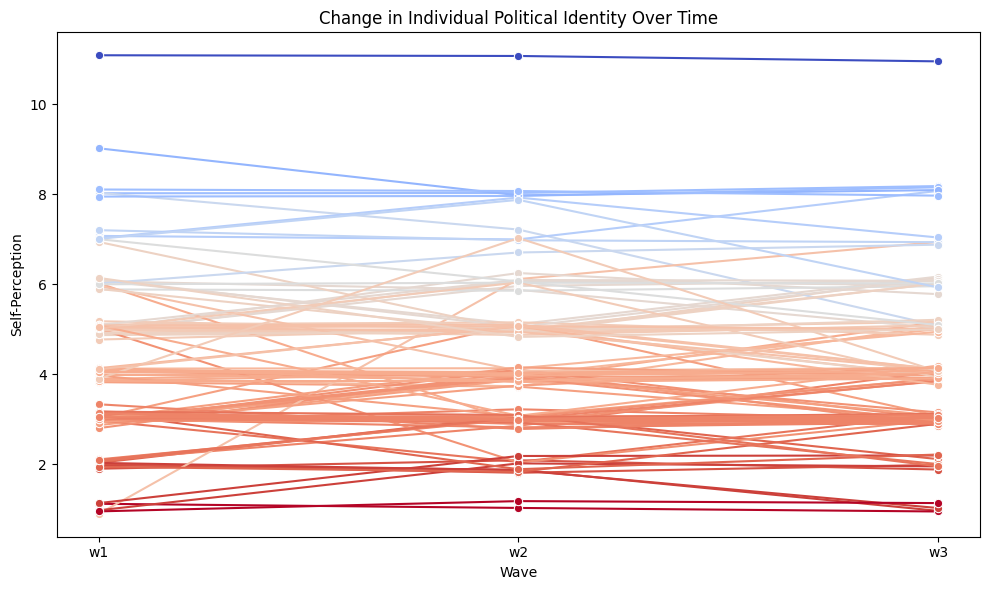

In [6]:
#### Step 1: Get average ego_score per participant!!!
participant_means = df_long.groupby('participant_id')['ego_score'].mean()

# Step 2: Normalize these scores
norm = Normalize(vmin=participant_means.min(), vmax=participant_means.max())

# Step 3: Get the colormap (blue-white-red)
cmap = get_cmap('coolwarm').reversed()

# Step 4: Map each participant to a color
participant_colors = {pid: cmap(norm(score)) for pid, score in participant_means.items()}

jitter_strength = 0.1
df_long['ego_jittered'] = df_long['ego_score'] + np.random.normal(0, jitter_strength, size=len(df_long))

# Step 5: Plot each line individually with its mapped color
plt.figure(figsize=(10, 6))
for pid, group in df_long.groupby('participant_id'):
    sns.lineplot(data=group, x='wave', y='ego_jittered', marker='o',
                 color=participant_colors[pid])

plt.title('Change in Individual Political Identity Over Time')
plt.ylabel('Self-Perception')
plt.xlabel('Wave')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()


***
## Variables for Analysis 

- Try to use the Graphs for the same task
- Keys for the dictionaries are allways the 3-Sign-Codes

In [14]:
def dictionary_polident_self_factory(G):
    # Create self-identity dictionary
    dict_polident_self = {}
    for node, value in G.nodes(data="linksrechts_self"):
        dict_polident_self[node] = value if value != 0 else np.nan
    
    return dict_polident_self

In [15]:
dict_polident_w1_perception_of_self = dictionary_polident_self_factory(G_1)
dict_polident_w2_perception_of_self = dictionary_polident_self_factory(G_2)
dict_polident_w3_perception_of_self = dictionary_polident_self_factory(G_3)

Filter Relation Types:
- `aquaintance` (default value)
- `study`
- `friend`
- `council`
- `politics`

Other Relation Types: (Note: filtering on these does not make sense!) 
- `sentiment`
- `leftright`

In [16]:
def dictionary_polident_others_factory(G, relation_filter="aquaintance"):

    # Create perception dictionary
    dict_politdent_perception = defaultdict(dict)
    
    for u, v, d in G.edges(data=True):
        # Check if it's a leftright edge AND has the specified relation
        if d.get('type') == 'leftright':
            # Check if there's a separate edge with the specified relation type
            if G.has_edge(u, v):
                relation_data = G.get_edge_data(u, v)
                if any(edge_data.get('type') == relation_filter for edge_data in relation_data.values()):
                    if d['weight'] != 0:
                        dict_politdent_perception[u][v] = d['weight']
    
    return dict_politdent_perception

In [22]:
# Remember: Here the key is basically the person doing the perceiving, either of self or of others
dict_polident_w1_perception_of_aquaintances = dictionary_polident_others_factory(G_1, "aquaintance")
dict_polident_w2_perception_of_aquaintances = dictionary_polident_others_factory(G_2, "aquaintance")
dict_polident_w3_perception_of_aquaintances = dictionary_polident_others_factory(G_3, "aquaintance")

dict_polident_w1_perception_of_friends = dictionary_polident_others_factory(G_1, "friend")
dict_polident_w2_perception_of_friends = dictionary_polident_others_factory(G_2, "friend")
dict_polident_w3_perception_of_friends = dictionary_polident_others_factory(G_3, "friend")

In [18]:
def dictionary_variable_factory(G, variable_name):
    dict_grades = {}

    for key, value in G.nodes(variable_name):
        if value != -999: #filter out missing values and non-answers 
            dict_grades[key] = value
        else:
            dict_grades[key] = np.nan

    return dict_grades

In [19]:
dict_gradexpec_w1 = dictionary_variable_factory(G_1, "grade")
dict_gradexpec_w2 = dictionary_variable_factory(G_2, "grade")
dict_gradexpec_w3 = dictionary_variable_factory(G_3, "grade")

In [23]:
print("How the own identity is perceived:", dict_polident_w2_perception_of_self["ddh"])
print("How aquaintances are perceived:", dict_polident_w2_perception_of_aquaintances["ddh"])
print("How friends are perceived:", dict_polident_w2_perception_of_friends["ddh"])
print("The grade expectation for oneself:", dict_gradexpec_w2["ddh"])

How the own identity is perceived: 3.0
How aquaintances are perceived: {'ceh': 3, 'kry': 7, 'gye': 4, 'hhb': 3, 'tdq': 3, 'rbc': 2, 'cnu': 1}
How friends are perceived: {'ceh': 3, 'gye': 4, 'hhb': 3, 'tdq': 3, 'rbc': 2, 'cnu': 1}
The grade expectation for oneself: 2.0
